# Cicero-similis Latin Language Model demo
This notebook was used to support a talk I gave at the Cicero Digitalis Conference on Feb 25, 2021
video here: https://www.youtube.com/watch?v=tJwmXZHZ924

In [1]:
from transformers import BertForMaskedLM, AutoTokenizer, FillMaskPipeline

In [2]:
tokenizer = AutoTokenizer.from_pretrained("cook/cicero-similis")
model = BertForMaskedLM.from_pretrained("cook/cicero-similis")

In [3]:
fill_mask = FillMaskPipeline(model=model, tokenizer=tokenizer)
fill_mask.top_k = 125
# Cicero, De Re Publica, VI, 32, 2
# "animal" is found in A, Q, PhD manuscripts
# 'anima' H^1 Macr. et codd. Tusc.
results = fill_mask("inanimum est enim omne quod pulsu agitatur externo; quod autem est [MASK],")
predicted_token_ids = [datum['token'] for datum in results]
predicted_words = tokenizer.convert_ids_to_tokens(predicted_token_ids)
animal_idx, anima_idx = predicted_words.index('animal'), predicted_words.index('anima') 
print(f"Using partial sentence, `animal` predicted at index: {animal_idx}; `anima` at {anima_idx}")

Using partial sentence, `animal` predicted at index: 11; `anima` at 113


In [4]:
fill_mask.top_k = 100
results = fill_mask("""
inanimum est enim omne quod pulsu agitatur externo; quod autem est [MASK], 
id motu cietur interiore et suo, nam haec est propria natura animi atque uis; 
quae si est una ex omnibus quae sese moueat, neque nata certe est et aeterna est.""")
predicted_token_ids = [datum['token'] for datum in results]
predicted_words = tokenizer.convert_ids_to_tokens(predicted_token_ids)
animal_idx, anima_idx = predicted_words.index('animal'), predicted_words.index('anima') 
print(f"Using full sentence, `animal` predicted at index: {animal_idx}; `anima` at {anima_idx}")

Using full sentence, `animal` predicted at index: 8; `anima` at 27


In [5]:
results[:3]

[{'sequence': 'inanimum est enim omne quod pulsu agitatur externo ; quod autem est corpus, id motu cietur interiore et suo, nam haec est propria natura animi atque uis ; quae si est una ex omnibus quae sese moueat, neque nata certe est et aeterna est.',
  'score': 0.03179331496357918,
  'token': 870,
  'token_str': 'corpus'},
 {'sequence': 'inanimum est enim omne quod pulsu agitatur externo ; quod autem est natura, id motu cietur interiore et suo, nam haec est propria natura animi atque uis ; quae si est una ex omnibus quae sese moueat, neque nata certe est et aeterna est.',
  'score': 0.026661323383450508,
  'token': 850,
  'token_str': 'natura'},
 {'sequence': 'inanimum est enim omne quod pulsu agitatur externo ; quod autem est inane, id motu cietur interiore et suo, nam haec est propria natura animi atque uis ; quae si est una ex omnibus quae sese moueat, neque nata certe est et aeterna est.',
  'score': 0.024686694145202637,
  'token': 11020,
  'token_str': 'inane'}]

# Sentence Probabilities

In [6]:
# Add parent dir, so we can access our common code
import os, sys, inspect
currentdir = os.path.dirname(os.path.abspath(inspect.getfile(inspect.currentframe())))
parentdir = os.path.dirname(currentdir)
sys.path.insert(0,parentdir) 

from mlyoucanuse.bert_fun import (
    get_alternate_words, 
    get_word_probabilities,
    get_word_in_sentence_probability, 
    sum_log_probabilities) 
from cltk.stem.latin.j_v import JVReplacer
replacer = JVReplacer()

from cltk.tokenize.word import WordTokenizer
latin_tokenizer = WordTokenizer('latin')
def clean(text):
    return ' '.join(latin_tokenizer.tokenize(replacer.replace(text)))


In [7]:
# Cicero, De Senectute, II,2
malum_potest_sentence ="""Rem haud sane difficilem, Scipio et Laeli, admirari uidemini;
 quibus enim nihil est in ipsis opis ad bene beateque vivendum, eis omnis aetas gravis est;
  qui autem omnia bona a se ipsi petunt, eis nihil malum potest videri quod naturae necessitas afferat."""

potest_malum_sentence = """Rem haud sane difficilem, Scipio et Laeli, admirari videmini;
 quibus enim nihil est in ipsis opis ad bene beateque vivendum, eis omnis aetas gravis est;
  qui autem omnia bona a se ipsi petunt, eis nihil potest malum videri quod naturae necessitas afferat."""

In [8]:
res = get_word_probabilities(clean(malum_potest_sentence), 
                             bert_tokenizer=tokenizer, bert_model=model)
sum_log_probabilities(res, boost_factor=1)

-205.22707244920045

In [9]:
res = get_word_probabilities(clean(potest_malum_sentence), 
                             bert_tokenizer=tokenizer, bert_model=model)
sum_log_probabilities(res, boost_factor=1)

-205.5083616649547

In [10]:
res = get_word_probabilities(clean('quid est veritas.'), bert_tokenizer=tokenizer, bert_model=model)
res

(('quid', ('quid',), (0.0005871062749065459,)),
 ('est', ('est',), (0.23766015470027924,)),
 ('ueritas', ('ueritas',), (2.761857285804581e-05,)),
 ('.', ('.',), (0.00977017916738987,)))

In [11]:
sum_log_probabilities(res, boost_factor=1)

-24.002660810659727

In [12]:
 0.0005871062749065459 * 0.23766015470027924 * 2.761857285804581e-05 * 0.00977017916738987

3.7651029780095805e-11

In [20]:
from cltk.corpus.readers import get_corpus_reader
from cltk.stem.latin.j_v import JVReplacer
from cltk.tokenize.latin.sentence import SentenceTokenizer
from cltk.tokenize.word import WordTokenizer

from mlyoucanuse.aeoe_replacer import AEOEReplacer
from mlyoucanuse.text_cleaners import ( normalize_accents, disappear_angle_brackets,
                                        drop_punct, disappear_round_brackets,
                                        truecase, dehyphenate, accept_editorial,
                                        swallow_braces, swallow_obelized_words,
                                        swallow_square_brackets)
from tqdm import tqdm
import random

In [18]:
tesserae = get_corpus_reader(corpus_name='latin_text_tesserae', language='latin')
cicero_files = [ file for file in tesserae.fileids() if '/cicero' in file] 
len(cicero_files)


122

In [19]:
test_sentences = []

In [27]:
import numpy as np

In [23]:
tesserae = get_corpus_reader(corpus_name='latin_text_tesserae', language='latin')
jv_replacer = JVReplacer()
aeoe_replacer = AEOEReplacer()
toker = WordTokenizer('latin')
sent_toker = SentenceTokenizer()


for file in tqdm(cicero_files,  total=len(cicero_files)):
    curr_finds = 0
    for sent in tesserae.sents(file):
        sent = aeoe_replacer.replace(jv_replacer.replace(sent))
        sent = normalize_accents(sent)
        sent = accept_editorial(sent)
        tokens = toker.tokenize(sent)
        if curr_finds > 10:
            continue
        if len(tokens) >7:
            mask_idx = random.randint(0, len(tokens)-1)
            masked_token = tokens[mask_idx] + ""
            tokens[mask_idx] ="[MASK]"
            test_sentences.append( (masked_token, ' '.join(tokens))  )
            curr_finds +=1
            
            
            
 

100%|██████████| 122/122 [00:22<00:00,  5.35it/s]


In [24]:
hundred = random.sample(test_sentences, 100)

In [33]:
import matplotlib.pyplot as plt

In [25]:
test_sentences[:2]

[('nobis',
  'In Cumano nuper cum cum me Atticus noster esset , nuntiatum est [MASK] a M. Uarro -ne uenisse eum Roma pridie uesperi et , nisi de uia fessus esset , continuo ad nos uenturum fuisse .'),
 ('hominem',
  'quod cum audissemus , nullam moram interponendam putauimus quin uideremus [MASK] cum nobis et studiis eisdem et uetustate amicitiae coniunctum ; itaque confestim ad eum ire perreximus .')]

In [36]:
fill_mask.top_k = 1000
scores=[]
for goal_word, test_sent in random.sample(test_sentences,200):    
    results = fill_mask(test_sent)
    predicted_token_ids = [datum['token'] for datum in results]
    predicted_words = tokenizer.convert_ids_to_tokens(predicted_token_ids)
    if goal_word in predicted_words:
        idx = predicted_words.index(goal_word)
        scores.append(idx)
    else:
        scores.append(1000)

In [37]:
ar_scores = np.array(scores)
np.std(ar_scores), np.mean(ar_scores)

(419.52718279034076, 285.73)

In [38]:
scores

[1000,
 93,
 0,
 0,
 28,
 951,
 2,
 0,
 0,
 1000,
 104,
 6,
 1000,
 10,
 30,
 0,
 87,
 1,
 30,
 11,
 1000,
 4,
 237,
 833,
 1,
 19,
 89,
 1000,
 683,
 1,
 44,
 311,
 13,
 1000,
 11,
 0,
 1,
 0,
 7,
 470,
 3,
 921,
 7,
 1000,
 1000,
 30,
 870,
 49,
 6,
 45,
 1000,
 70,
 0,
 19,
 4,
 1000,
 13,
 14,
 1000,
 175,
 23,
 283,
 5,
 0,
 0,
 29,
 1000,
 1000,
 1000,
 0,
 1000,
 0,
 0,
 82,
 31,
 275,
 1000,
 0,
 0,
 1000,
 43,
 251,
 1000,
 1,
 2,
 1000,
 1,
 1000,
 0,
 1000,
 1000,
 14,
 0,
 46,
 1000,
 486,
 0,
 1,
 1000,
 1000,
 28,
 1000,
 20,
 6,
 0,
 0,
 1000,
 1000,
 1000,
 4,
 0,
 9,
 5,
 4,
 0,
 9,
 2,
 45,
 1,
 177,
 0,
 2,
 0,
 1,
 197,
 7,
 1000,
 1000,
 0,
 0,
 0,
 0,
 6,
 47,
 10,
 5,
 1000,
 3,
 3,
 0,
 129,
 21,
 152,
 0,
 15,
 1000,
 1000,
 6,
 1,
 40,
 1000,
 1000,
 675,
 2,
 1000,
 0,
 1000,
 0,
 1,
 1000,
 1000,
 0,
 51,
 128,
 254,
 0,
 172,
 2,
 131,
 445,
 1000,
 73,
 6,
 0,
 1000,
 0,
 37,
 82,
 32,
 3,
 4,
 1,
 1000,
 1,
 2,
 0,
 0,
 1000,
 0,
 71,
 0,
 113,
 0,
 0,
 1

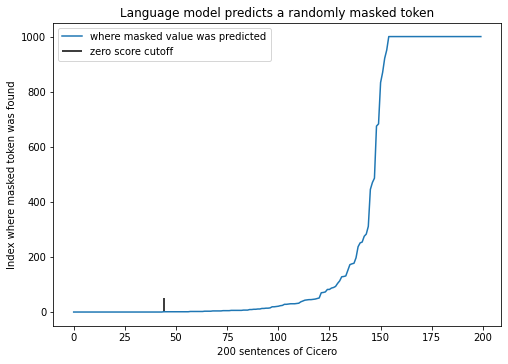

In [51]:
fig = plt.figure(figsize=(7,5))
plt.plot(sorted(scores), label='where masked value was predicted')
plt.xlabel("200 sentences of Cicero")
plt.vlines(44, 0, 50, label="zero score cutoff")
plt.ylabel("Index where masked token was found")
plt.title("Language model predicts a randomly masked token")
plt.tight_layout(pad=0.5, w_pad=20, h_pad=0.5)
plt.legend()
plt.savefig('200sentence.test.png')


In [35]:
len(test_sentences)

1366

In [44]:
scores.count(0)

44